In [217]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.special import expit
from sklearn.utils.extmath import log_logistic
from matplotlib import pyplot as plt
from collections import OrderedDict

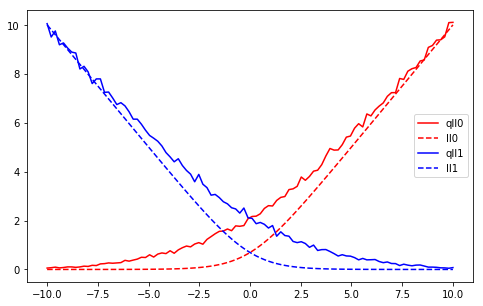

In [2]:
def LL(y, z):
    """
    Logistic loss
    """
    return -log_logistic(y * z)

def qLLmc(y, mu, scale, nsamples=100):
    """
    Expected value of logistic loss over gaussian density using Monte-Carlo approximation
    \int p(z; mu, sigma2) log(1 + exp(-yz)) dz
    """
    z = LL(y, np.random.normal(loc=mu, scale=scale, size=nsamples))
    return np.mean(z)

m = np.linspace(-10, 10, 100)
qll0 = map(lambda m: qLLmc(-1, m, scale=5.0, nsamples=1000), m)
ll0 = LL(y=-1, z=m)
qll1 = map(lambda m: qLLmc( 1, m, scale=5.0, nsamples=1000), m)
ll1 = LL(y= 1, z=m)

fh = plt.figure(figsize=[8,5])
qll0_line, = plt.plot(m, qll0, 'r-', label='qll0')
ll0_line, = plt.plot(m, ll0, 'r--', label='ll0')
qll1_line, = plt.plot(m, qll1, 'b-', label='qll1')
ll1_line, = plt.plot(m, ll1, 'b--', label='ll1')
plt.legend(handles=[qll0_line, ll0_line, qll1_line, ll1_line])
plt.show()

# Exercises:
# * modify nsamples to see quality of Monte-Carlo approximation
# * modify scale to see how qLL converges to LL at smaller scales

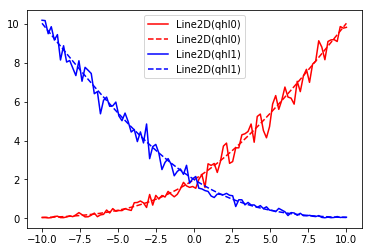

In [3]:
# Метод Сергея: заменить лог-лосс на хинж-лосс, после чего интегралы берутся
def HL(y, z):
    """
    Hinge loss
    """
    return np.maximum(- y * z, 0)

def qHLmc(y, mu, scale, nsamples=100):
    z = HL(y, np.random.normal(loc=mu, scale=scale, size=nsamples))
    return np.mean(z)

def qHL(y, mu, scale):
    t = mu / scale
    return  - y * mu * norm.cdf(- y * t) + scale * norm.pdf(t)

m = np.linspace(-10, 10, 100)
qhlmc0 = map(lambda m: qHLmc(-1, m, scale=5.0, nsamples=100), m)
qhl0 = map(lambda m: qHL(-1, m, scale=5.0), m)
qhlmc1 = map(lambda m: qHLmc(1, m, scale=5.0, nsamples=100), m)
qhl1 = map(lambda m: qHL(1, m, scale=5.0), m)

qhlmc0_line, = plt.plot(m, qhlmc0, 'r-', label='qhl0')
qhl0_line, = plt.plot(m, qhl0, 'r--', label='qhl0')
qhlmc1_line, = plt.plot(m, qhlmc1, 'b-', label='qhl1')
qhl1_line, = plt.plot(m, qhl1, 'b--', label='qhl1')
plt.legend([qhlmc0_line, qhl0_line, qhlmc1_line, qhl1_line])
plt.show()

# Exercises:
# * modify scale and nsamples to see how qHLmc converges to exact qHL at larger sample sizes

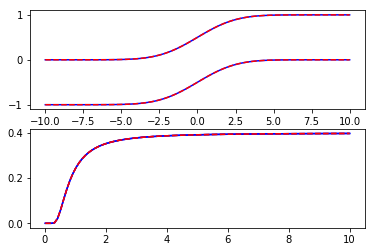

In [5]:
# Метод Сергея - производные
def dqHL_dmu(y, mu, scale):
    t = mu / scale
    return - y * norm.cdf( - y * t)

def dqHL_dsc(y, mu, scale):
    # In fact does not depend on y
    t = mu / scale
    return norm.pdf(t)

# Gradient check
f, [ax1, ax2] = plt.subplots(2)

m = np.linspace(-10, 10, 100)
dm = 1.e-5
df0_num = (qHL(-1, m + dm , scale=2.0) - qHL(-1, m - dm, scale=2.0)) / 2. / dm
df0_pre = dqHL_dmu(-1, m, scale=2.0)
df1_num = (qHL(1, m + dm , scale=2.0) - qHL(1, m - dm, scale=2.0)) / 2. / dm
df1_pre = dqHL_dmu(1, m, scale=2.0)
ax1.plot(m, df0_num, 'b-', m, df0_pre, 'r--')
ax1.plot(m, df1_num, 'b-', m, df1_pre, 'r--')

s = np.linspace(0.01, 10.0, 100)
ds = 1.e-5
df0_num = (qHL(-1, 1.0, scale=s + ds) - qHL(-1, 1.0, scale=s - ds)) / 2. / ds
df0_pre = dqHL_dsc(-1, 1.0, scale=s)
df1_num = (qHL(1, 1.0, scale=s + ds) - qHL(1, 1.0, scale=s - ds)) / 2. / ds
df1_pre = dqHL_dsc(1, 1.0, scale=s)
ax2.plot(s, df0_num, 'b-', s, df0_pre, 'r--')
ax2.plot(s, df1_num, 'b-', s, df1_pre, 'r--')

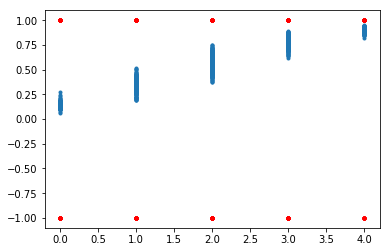

In [161]:
# Synthetic data
N = 1000
M = 5
w = np.array([-2.1, -1.0, 0.0, 1.0, 2.0])
x = np.random.choice([0, 1, 2, 3, 4], p=[0.1, 0.2, 0.3, 0.3, 0.1], size=N)
z = 0.3 + w[x] + np.random.normal(loc=0.0, scale=0.3, size=N)
y = 2 * np.random.binomial(np.ones(N, dtype='int64'), p=expit(z), size=N) - 1
plt.plot(x, expit(z), '.', x, y, 'r.')

# convert to one-hot encoding
X = np.zeros([N, M+1])
for j in xrange(N):
    X[j, 0] = 1
    X[j, x[j] + 1] = 1

In [113]:
def objfcn(w, X, y, mu0=0.0, scale0=1.0):
    v = w[:M+1]
    u = w[M+1:]
    f = 0
    g = np.zeros(w.shape)
    for j, x in enumerate(X):
        mu = np.dot(x, v)
        scale = - log_logistic(-np.dot(x, u))[0, 0]
        f += qHL(y[j], mu, scale) 
        f += (mu - mu0)**2 / 2. / scale0**2 
        f += 1./2. * (scale**2 / scale0**2 - 1.0) - np.log(scale / scale0)
        g_mu = dqHL_dmu(y[j], mu, scale)
        g_mu += (mu - mu0) / scale0**2
        g_scale = dqHL_dsc(y[j], mu, scale)
        g_scale += scale * (1. / scale0**2 - 1. / scale**2)
        g[:M+1] += g_mu * x
        g[M+1:] += g_scale * expit(np.dot(x, u)) * x
    return f, g

# Gradient check
w = np.random.rand(2*M + 2)
d = 1.e-6
for j in xrange(2*M + 2):
    dw = np.zeros(2*M + 2)
    dw[j] = d
    f, g = objfcn(w, X, y)
    fp, _ = objfcn(w + dw, X, y)
    fm, _ = objfcn(w - dw, X, y)
    print j, g[j], (fp - fm) / 2. / d

0 58.7268259705 58.7268261398
1 20.1152289741 20.1152289918
2 21.0029920008 21.0029919998
3 15.7121177106 15.7121177438
4 2.06027834201 2.06027843319
5 -0.163791057003 -0.163791057162
6 125.621712103 125.621712073
7 10.2557776727 10.2557776529
8 32.2989812779 32.2989812815
9 24.6538033975 24.6538033934
10 49.6974988418 49.6974988522
11 8.71565091354 8.71565087834
568.454571813 [ 0.06159662  0.75184428  0.25328447] [ 0.38174152  0.30270118  0.70648154]
59.4080377942 [-0.1124974   0.62257886  0.1771216 ] [-0.25372884  0.24550929  0.52653991]
51.0982893575 [-0.12307453  0.60207722  0.16918109] [-0.31459787  0.23999819  0.50716299]
47.2773879247 [-0.12808851  0.59040614  0.16500331] [-0.34608413  0.23714436  0.49688106]
44.9288713181 [-0.13122152  0.58227726  0.16222923] [-0.36677202  0.23526798  0.49001404]
43.2842042142 [-0.13344164  0.57605978  0.16017914] [-0.38194434  0.23389114  0.48491598]
42.0426511598 [-0.13513361  0.57103669  0.15856674] [-0.39380651  0.23281422  0.48089093]
41.0

In [162]:
# Compute solution
w = np.random.rand(2*M + 2)
eps = 1.e-4
for t in xrange(5000):
    f, g = objfcn(w, X, y, mu0=0.0, scale0=2.0)
    w -= eps * g
    if t % 500 == 0:
        print t, f, w[:3], w[M+1:M+4]
        
print 'learned weights for mu %s' % w[:M+1]
print 'learned weights for sigmas %s' % w[M+1:]

0 746.38546239 [ 0.31496473  0.03592643  0.00714989] [ 0.52708424  0.9586884   0.46068386]
500 607.577768497 [-0.05932873 -0.5141152  -0.22375006] [ 0.63721223  0.51727233  0.42963849]
1000 607.442162442 [-0.05904286 -0.55452475 -0.22510543] [ 0.63604813  0.48690086  0.43563954]
1500 607.440999436 [-0.05888282 -0.55773675 -0.22534293] [ 0.63623174  0.48453135  0.43553038]
2000 607.440985676 [-0.05885534 -0.55802471 -0.22538293] [ 0.63626379  0.48430155  0.43547965]
2500 607.440985501 [-0.05885159 -0.5580526  -0.22538849] [ 0.63626773  0.48427576  0.43547257]
3000 607.440985499 [-0.05885112 -0.55805538 -0.2253892 ] [ 0.63626817  0.48427264  0.43547175]
3500 607.440985499 [-0.05885106 -0.55805566 -0.22538929] [ 0.63626821  0.48427225  0.43547166]
4000 607.440985499 [-0.05885105 -0.55805569 -0.2253893 ] [ 0.63626822  0.4842722   0.43547166]
4500 607.440985499 [-0.05885105 -0.55805569 -0.22538931] [ 0.63626822  0.48427219  0.43547166]
learned weights for mu [-0.05885105 -0.55805569 -0.2253

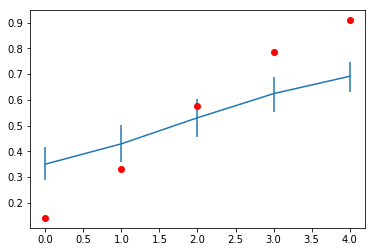

In [163]:
C = np.hstack([np.ones([5, 1]), np.identity(5)])
mu = np.dot(C, w[:M+1])
scale = - log_logistic(np.dot(C, w[M+1:]))
plt.errorbar(xrange(5), expit(mu), yerr=[expit(mu) - expit(mu-scale), expit(mu+scale) - expit(mu)])
plt.plot(expit(0.3 + np.array([-2.1, -1.0, 0.0, 1.0, 2.0])), 'ro')

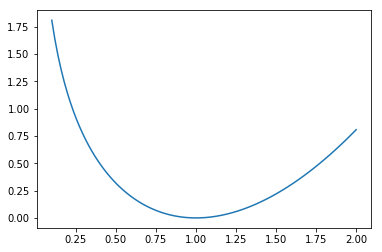

In [145]:
def reg_scale(s, s0):
    return (1. / 2.) * (s**2 / s0**2 - 1.0) - np.log(s / s0)

s = np.linspace(1.e-1, 2, 100)
r = reg_scale(s, 1.0)
plt.plot(s, r, '-')

In [191]:
def loss(y, mu, z, mu0=0.0, scale0=1.0):
    scale = np.log(1 + np.exp(z))
    l = - y * mu * norm.cdf(- y * mu / scale) + scale * norm.pdf(mu / scale)
    l += (mu - mu0)**2 / 2 / scale0**2 + (1./2.) * (scale**2 / scale0**2 - 1) - np.log(scale / scale0)
    return l
    
def grad(y, mu, z, mu0=0.0, scale0=1.0):
    scale = np.log(1 + np.exp(z))
    g = norm.pdf(mu / scale)  + scale * (1. / scale0**2 - 1. / scale**2)
    return g * expit(z)

def hess(y, mu, z, mu0=0.0, scale0=1.0):
    scale = np.log(1 + np.exp(z))
    dz = expit(z)
    d2z = dz * (1.0 - dz)
    phi = norm.pdf(mu / scale)
    h = mu**2 / scale**3 * phi * dz**2 + phi * d2z
    h += (1. / scale0**2 + 1. / scale**2) * dz**2 + scale * (1. / scale0**2 - 1. / scale**2) * d2z
    return h
    
# Gradient check
dz = 1.e-5
mu = 2.0
for z in np.linspace(-10, 10, 21):
    f = loss(1, mu, z)
    g = grad(1, mu, z)
    h = hess(1, mu, z)
    g_num = (loss(1, mu, z + dz) - loss(1, mu, z - dz)) / 2. / dz
    h_num = (grad(1, mu, z + dz) - grad(1, mu, z - dz)) / 2. / dz
    print z, f, g, g_num, h, h_num

-10.0 11.5000227006 -0.999977298833 -0.999977265703 2.27023691151e-05 2.26693386285e-05
-9.0 10.5000617093 -0.999938286215 -0.999938290391 6.17226633559e-05 6.17268292036e-05
-8.0 9.50016776412 -0.999832203083 -0.999832225546 0.00016786247797 0.000167884989244
-7.0 8.50045618323 -0.999543574811 -0.99954356747 0.00045690854465 0.00045690121131
-6.0 7.50124116245 -0.998757056866 -0.998757054305 0.00124649315832 0.00124649057742
-5.0 6.50338210119 -0.996604884312 -0.99660488444 0.00342091978425 0.00342091998062
-4.0 5.50925339969 -0.990653242719 -0.990653242994 0.00952910649213 0.00952910679253
-3.0 4.525572403 -0.973790748595 -0.973790748615 0.0274028805507 0.0274028805314
-2.0 3.57219055541 -0.924007838459 -0.924007838421 0.0823261686029 0.0823261685823
-1.0 2.70978281783 -0.774270948053 -0.774270948045 0.243348650819 0.243348650819
0.0 2.10713422863 -0.371669185112 -0.371669185095 0.603153389782 0.60315338978
1.0 2.12633453205 0.494857446708 0.494857446731 1.09550402428 1.09550402428
2

In [291]:
# Synthetic dataset
def gen_dataset(N, mode='train', noise=0.1):
    def fcn(f1, f2):
        #return 3. * f1 / np.sqrt(f1**2 + f2**2)
        return 0.0
        
    if mode == 'train':
        f = np.random.randn(N, 2)
        z = fcn(f[:, 0], f[:, 1]) + noise * np.random.randn(N)
        p = expit(z)
        c = np.random.binomial(np.ones([N], dtype='int64'), p)
        
        return pd.DataFrame(data=OrderedDict(
            qid=np.zeros([N], dtype='int32'),
            mu = z,
            target=c,
            url=range(N),
            weight=np.ones([N]),
            f1=f[:, 0],
            f2=f[:, 1]
        ))
        
        
    if mode == 'test':
        f = np.array([[f1, f2] for f1 in np.linspace(-5, 5, N) for f2 in np.linspace(-5, 5, N)])
        z = fcn(f[:, 0], f[:, 1])
        p = expit(z)
        
        return pd.DataFrame(data={
            'qid': np.zeros([N*N]),
            'target': z,
            'url': np.zeros([N*N]),
            'weight': np.ones([N*N]),
            'f1': f[:, 0],
            'f2': f[:, 1]
        })
       
# write train data
df = gen_dataset(N=10000)
df[['qid', 'target', 'url', 'weight', 'f1', 'f2']].to_csv('train.tsv', header=False, sep='\t', index=False)
df[['qid', 'mu', 'url', 'weight', 'f1', 'f2']].to_csv('train_sigma.tsv', header=False, sep='\t', index=False)
pd.DataFrame(data={'baseline': np.ones([1000])}).to_csv('train_sigma.tsv.baseline', header=False, sep='\t', index=False)

# write test data
df_test = gen_dataset(N=100, mode='test')
df_test = df_test[['qid', 'target', 'url', 'weight', 'f1', 'f2']]
df_test.to_csv('test.tsv', header=False, sep='\t', index=False)

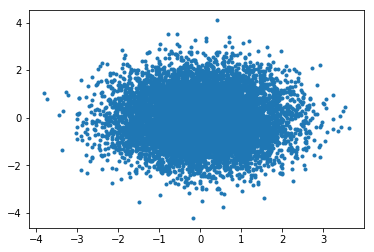

In [292]:
X = df_test.f1.as_matrix().reshape([100, 100])
Y = df_test.f2.as_matrix().reshape([100, 100])
Z = df_test.target.as_matrix().reshape([100, 100])
#plt.imshow(Z)
plt.plot(df.f1, df.f2, '.')

test.tsv.matrixnet                            100%  292KB 292.2KB/s   00:00    


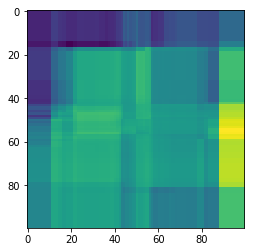

In [293]:
! scp stys@simulator:/home/stys/test.tsv.matrixnet .
df_test_results = pd.read_csv('test.tsv.matrixnet', sep='\t', header=None)
df_test_results.columns = ['qid', 'target', 'url', 'weight', 'pred']
df_test_results.head()
Z = df_test_results.pred.as_matrix().reshape([100, 100])
plt.imshow(Z)

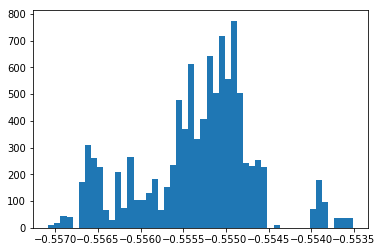

In [294]:
plt.hist(df_test_results.pred, bins=50);

In [290]:
np.log(1 + np.exp(-0.555))

0.45366605821487932